# Predicting T-shirt size using the ANSUR II dataset
We will here try to predict a persons t-shirt size given the weight and height of the person. We will use the ANSUR II dataset which contains a lot of information about the physical attributes of a large number of people. 

We will first try to map the persons in the dataset to a t-shirt size. It is hard to find a concise size chart for t-shirt so we will create our own, initial chart, based on these assumptions:

We will only look at two measurements, Shoulder Width and Chest Circumference.

Our first problem is that Shoulder Width is not one of the measurements taken in the dataset. But we have Biacromial Breadth which is the distance between the two acromion processes. We will assume that this is the same as Shoulder Width.

We will then have these initial rules:

| Size | Percentile |
|------|------------|
| XS   | 0-5        |
| S    | 5-25       |
| M    | 25-50      |
| L    | 50-75      |
| XL   | 75-90      |
| XXL  | 90-97      |
| XXXL | 97-100     |

## Inspect the data

In [876]:
import pandas as pd

In [877]:
female = pd.read_csv('./female.csv')
male = pd.read_csv('./male.csv')

In [878]:
print(f'For women we have (rows, columns) {female.shape}')
print(f'For women we have (rows, columns) {male.shape}')


For women we have (rows, columns) (1986, 108)
For women we have (rows, columns) (4082, 108)


## Checking the percentiles

In [879]:
def compute_percentile_ranges(column):
    # Define percentile ranges
    ranges = [(0, 5), (5, 25), (25, 50), (50, 75), (75,90), (90, 97), (97, 100)]

    percentiles = {(low, high): (column.quantile(low/100), column.quantile(high/100)) for low, high in ranges}

    counts = {}

    for r, (low, high) in percentiles.items():
        counts[r] = ((column >= low) & (column < high)).sum()
    
    return counts

print(compute_percentile_ranges(female['chestcircumference']))
print(compute_percentile_ranges(female['biacromialbreadth']))

print(compute_percentile_ranges(male['chestcircumference']))
print(compute_percentile_ranges(male['biacromialbreadth']))

{(0, 5): np.int64(100), (5, 25): np.int64(396), (25, 50): np.int64(492), (50, 75): np.int64(499), (75, 90): np.int64(299), (90, 97): np.int64(140), (97, 100): np.int64(59)}
{(0, 5): np.int64(93), (5, 25): np.int64(377), (25, 50): np.int64(477), (50, 75): np.int64(541), (75, 90): np.int64(297), (90, 97): np.int64(139), (97, 100): np.int64(61)}
{(0, 5): np.int64(199), (5, 25): np.int64(810), (25, 50): np.int64(1025), (50, 75): np.int64(1012), (75, 90): np.int64(616), (90, 97): np.int64(295), (97, 100): np.int64(124)}
{(0, 5): np.int64(191), (5, 25): np.int64(787), (25, 50): np.int64(989), (50, 75): np.int64(1079), (75, 90): np.int64(610), (90, 97): np.int64(303), (97, 100): np.int64(122)}


## Generate the t-shirt size chart

In [880]:
def compute_size_percentile_measurements(data, chest_column, shoulder_column):
    sizes = ['XS', 'S', 'M', 'L', 'XL', '2XL', '3XL']
    ranges = [0, 5, 25, 50, 75, 90, 97]

    #Compute the values for each percentile for chest and shoulder
    chest_percentiles = {p: data[chest_column].quantile(p/100) for p in ranges}
    shoulder_percentiles = {p: data[shoulder_column].quantile(p/100) for p in ranges}
    
    # Map the t-shirt sizes to the corresponding chest and shoulder measurements
    size_mappings = {}
    for i, size in enumerate(sizes):
        size_mappings[size] = {
            'Chest': int(chest_percentiles[ranges[i]]),
            'Shoulder': int(shoulder_percentiles[ranges[i]])
        }
    
    return size_mappings





female_sizes = (compute_size_percentile_measurements(female, 'chestcircumference', 'biacromialbreadth'))
male_sizes = (compute_size_percentile_measurements(male, 'chestcircumference', 'biacromialbreadth'))


In [881]:
# female_sizes = {
#     'XS': {'Chest': 695, 'Shoulder': 283}, 
#     'S': {'Chest': 824, 'Shoulder': 335}, # 824 -> 819-829
#     'M': {'Chest': 889, 'Shoulder': 353}, 
#     'L': {'Chest': 940, 'Shoulder': 365}, 
#     'XL': {'Chest': 999, 'Shoulder': 378}, 
#     '2XL': {'Chest': 1057, 'Shoulder': 389},   
#     '3XL': {'Chest': 1117, 'Shoulder': 400} # CHEST 1117  -> 1112 - 2117
#                                             # Shoulder 400 -> 395 - 1400
# }

# male_sizes = {
#     'XS': {'Chest': 774, 'Shoulder': 337}, 
#     'S': {'Chest': 922, 'Shoulder': 384}, 
#     'M': {'Chest': 996, 'Shoulder': 403}, 
#     'L': {'Chest': 1056, 'Shoulder': 415}, 
#     'XL': {'Chest': 1117, 'Shoulder': 428}, 
#     '2XL': {'Chest': 1172, 'Shoulder': 441}, 
#     '3XL': {'Chest': 1233, 'Shoulder': 452}
#     }

In [882]:
def get_size(data, size_chart):
    matches= {size: 0 for size in size_chart.keys()}
    ties = 0

    for _, row in data.iterrows():
        possible_sizes = []

        for size, measurements in size_chart.items():
            if (row['biacromialbreadth'] <= measurements['Shoulder'] and
                row['chestcircumference'] <= measurements['Chest']):
                possible_sizes.append(size)

        if len(possible_sizes) == 1: 
            matches[possible_sizes[0]] += 1
        elif len(possible_sizes) > 1: 
            ties += 1
    
    return matches, ties

In [883]:
female_matches, female_ties = get_size(female, female_sizes)
male_matches, male_ties = get_size(male, male_sizes)

print('Female matches:', female_matches)
print('Female ties:', female_ties)
print('male matches:', male_matches)
print('male ties:', male_ties)




Female matches: {'XS': 0, 'S': 0, 'M': 0, 'L': 0, 'XL': 0, '2XL': 0, '3XL': 236}
Female ties: 1642
male matches: {'XS': 0, 'S': 0, 'M': 0, 'L': 0, 'XL': 0, '2XL': 0, '3XL': 434}
male ties: 3437


This is not good. Let us have overlapping measurments

In [884]:
def create_overlapping_size_chart(original_chart):
    overlapping_chart = {}

    sizes = list(original_chart.keys())

    for i, size in enumerate(sizes):
        overlapping_chart[size] = {}
        if i == 0:
            overlapping_chart[size]['Chest'] = [original_chart[size]['Chest'], original_chart[sizes[i+1]]['Chest']+5]
            overlapping_chart[size]['Shoulder'] = [original_chart[size]['Shoulder'], original_chart[sizes[i+1]]['Shoulder']+5]

        elif i == len(sizes)-1:
            overlapping_chart[size]['Chest'] = [original_chart[size]['Chest']-5, original_chart[size]['Chest']+1000]
            overlapping_chart[size]['Shoulder'] = [original_chart[size]['Shoulder']-5, original_chart[size]['Shoulder']+1000]
        
        else:
            overlapping_chart[size]['Chest'] = [original_chart[size]['Chest']-5, original_chart[sizes[i+1]]['Chest']+8]
            overlapping_chart[size]['Shoulder'] = [original_chart[size]['Shoulder']-5, original_chart[sizes[i+1]]['Shoulder']+8]
    
    return overlapping_chart

In [885]:
new_female_sizes = create_overlapping_size_chart(female_sizes)
new_male_sizes = create_overlapping_size_chart(male_sizes)

for k, v in new_female_sizes.items():
    print(f"'{k}': {v},")

print()

for k, v in new_male_sizes.items():
    print(f"'{k}': {v},")




'XS': {'Chest': [695, 829], 'Shoulder': [283, 340]},
'S': {'Chest': [819, 897], 'Shoulder': [330, 361]},
'M': {'Chest': [884, 948], 'Shoulder': [348, 373]},
'L': {'Chest': [935, 1007], 'Shoulder': [360, 386]},
'XL': {'Chest': [994, 1065], 'Shoulder': [373, 397]},
'2XL': {'Chest': [1052, 1125], 'Shoulder': [384, 408]},
'3XL': {'Chest': [1112, 2117], 'Shoulder': [395, 1400]},

'XS': {'Chest': [774, 927], 'Shoulder': [337, 389]},
'S': {'Chest': [917, 1004], 'Shoulder': [379, 411]},
'M': {'Chest': [991, 1064], 'Shoulder': [398, 423]},
'L': {'Chest': [1051, 1125], 'Shoulder': [410, 436]},
'XL': {'Chest': [1112, 1180], 'Shoulder': [423, 449]},
'2XL': {'Chest': [1167, 1241], 'Shoulder': [436, 460]},
'3XL': {'Chest': [1228, 2233], 'Shoulder': [447, 1452]},


In [886]:
# female_sizes = {
# 'XS': {'Chest': [695, 829], 'Shoulder': [283, 340]},
# 'S': {'Chest': [819, 894], 'Shoulder': [330, 358]},
# 'M': {'Chest': [884, 945], 'Shoulder': [348, 370]},
# 'L': {'Chest': [935, 1004], 'Shoulder': [360, 383]},
# 'XL': {'Chest': [994, 1062], 'Shoulder': [373, 394]},
# '2XL': {'Chest': [1052, 1122], 'Shoulder': [384, 405]},
# '3XL': {'Chest': [1112, 2117], 'Shoulder': [395, 1400]},
# }


# male_sizes ={
# 'XS': {'Chest': [774, 927], 'Shoulder': [337, 389]},
# 'S': {'Chest': [917, 1001], 'Shoulder': [379, 408]},
# 'M': {'Chest': [991, 1061], 'Shoulder': [398, 420]},
# 'L': {'Chest': [1051, 1122], 'Shoulder': [410, 433]},
# 'XL': {'Chest': [1112, 1177], 'Shoulder': [423, 446]},
# '2XL': {'Chest': [1167, 1238], 'Shoulder': [436, 457]},
# '3XL': {'Chest': [1228, 2233], 'Shoulder': [447, 1452]},
# }

In [887]:
def get_size(data, size_chart):
    matches= {size: 0 for size in size_chart.keys()}
    ties = 0

    size_ordered = list(size_chart.keys())

    for _, row in data.iterrows():
        possible_sizes = []

        for size, measurements in size_chart.items():
            if (row['biacromialbreadth'] >= measurements['Shoulder'][0] and 
                row['biacromialbreadth']<= measurements['Shoulder'][1] and
                row['chestcircumference'] >= measurements['Chest'][0] and
                row['chestcircumference'] <= measurements['Chest'][1]):
                possible_sizes.append(size)
        
        if len(possible_sizes) == 1:
            matches[possible_sizes[0]] += 1
        elif len(possible_sizes) > 1: 
            # Check if sizes are adjacent 
            are_adjacent = all([abs(size_ordered.index(possible_sizes[i]) - size_ordered.index(possible_sizes[i+1])) == 1
                               for i in range(len(possible_sizes)-1)])
            
            if are_adjacent:
                # Assign the larger size
                larger_size = max(possible_sizes, key=lambda s: size_ordered.index(s))
                matches[larger_size] += 1
            else:
                ties += 1
    
    return matches, ties
            




In [888]:
# all-function example:

result = all([True, True, False])
print(result)


x = 10
result = all([x < 15, x == 10, x > 12])
print(result)

False
False


In [889]:
female_matches, female_ties = get_size(female, new_female_sizes)
male_matches, male_ties = get_size(male, new_male_sizes)

print('Female matches:', female_matches)
print('Female ties:', female_ties)
print('male matches:', male_matches)
print('male ties:', male_ties)




Female matches: {'XS': 23, 'S': 225, 'M': 283, 'L': 298, 'XL': 128, '2XL': 37, '3XL': 13}
Female ties: 0
male matches: {'XS': 63, 'S': 482, 'M': 652, 'L': 641, 'XL': 352, '2XL': 106, '3XL': 50}
male ties: 0


In [890]:
def determine_size(value, measurement, size_dict):
    """
    Determine clothing sizes that match the given body measurement value.
    
    Iterates through the provided size dictionary and finds all sizes where the 
    measurement range contains the given value.
    
    Parameters:
      value: The body measurement value
      measurement: The name of the measurement type
      size_dict: Dictionary mapping clothing sizes to measurement ranges
    
    Returns:
      sizes: List of clothing sizes matching the measurement value
    """
    sizes = []
    for size, measurements in size_dict.items():
        if measurements[measurement][0] <= value <= measurements[measurement][1]:
            sizes.append(size)
    return sizes

def determine_individual_size(row, size_dict):
    """
    Determine individual clothing size based on chest circumference and shoulder width.
    Matches the chest and shoulder measurements to clothing sizes in the provided size dictionary. 
    Returns a single matching size, or the larger of two adjacent sizes if there are multiple matches.
    Returns None if no size matches or adjacent sizes cannot be determined.
    """
    chest_size = determine_size(row['chestcircumference'], 'Chest', size_dict)
    shoulder_size = determine_size(row['biacromialbreadth'], 'Shoulder', size_dict)
    
    matching_sizes = list(set(chest_size) & set(shoulder_size))
    
    if len(matching_sizes) == 1:
        return matching_sizes[0]
    elif len(matching_sizes) > 1:
        # Check if sizes are adjacent, if so, select the larger size
        size_order = list(size_dict.keys())
        adjacent = all([abs(size_order.index(a) - size_order.index(b)) <= 1 for a in matching_sizes for b in matching_sizes])
        if adjacent:
            return max(matching_sizes, key=lambda x: size_order.index(x))
    return None

In [891]:
female['t-shirt size'] = female.apply(determine_individual_size, args=(new_female_sizes,), axis=1)
male['t-shirt size'] = male.apply(determine_individual_size, args=(new_male_sizes,), axis=1)


In [892]:
female['t-shirt size'].value_counts()

t-shirt size
L      298
M      283
S      225
XL     128
2XL     37
XS      23
3XL     13
Name: count, dtype: int64

In [893]:
male['t-shirt size'].value_counts()

t-shirt size
M      652
L      641
S      482
XL     352
2XL    106
XS      63
3XL     50
Name: count, dtype: int64

In [894]:
female_filtered = female.dropna(subset=['t-shirt size'])
male_filtered = male.dropna(subset=['t-shirt size'])


In [895]:
female_filtered.shape

(1007, 109)

In [896]:
male_filtered.shape

(2346, 109)

In [897]:
columns = ['chestcircumference', 'biacromialbreadth', 'weightkg', 'waistbreadth', 't-shirt size']

female_dataset = female_filtered[columns]
male_dataset = male_filtered[columns]


In [898]:
female_dataset.to_csv('./female_sized.csv', index=False)
male_dataset.to_csv('./male_sized.csv', index=False)


## Why Create a Scatter Plot

Visualize the Distribution of t-shirt Sizes

Identify Patterns or Trends

Compare Men and Women

Communicate Results

Identify Potential Anomalies or Outliers


/tmp/ipykernel_4671/2634041543.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[32.9 35.5 35.2 ... 35.1 33.3 35.4]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  male_dataset.loc[:, 'waistbreadth'] = male_dataset['waistbreadth'] / 10
/tmp/ipykernel_4671/2634041543.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 92.9 116.2  95.4 ...  89.6  83.2  98.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  male_dataset.loc[:, 'weightkg'] = male_dataset['weightkg'] / 10
/tmp/ipykernel_4671/2634041543.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[29.5 30.2 33.8 ... 33.6 33.4 29.9]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  female_datas

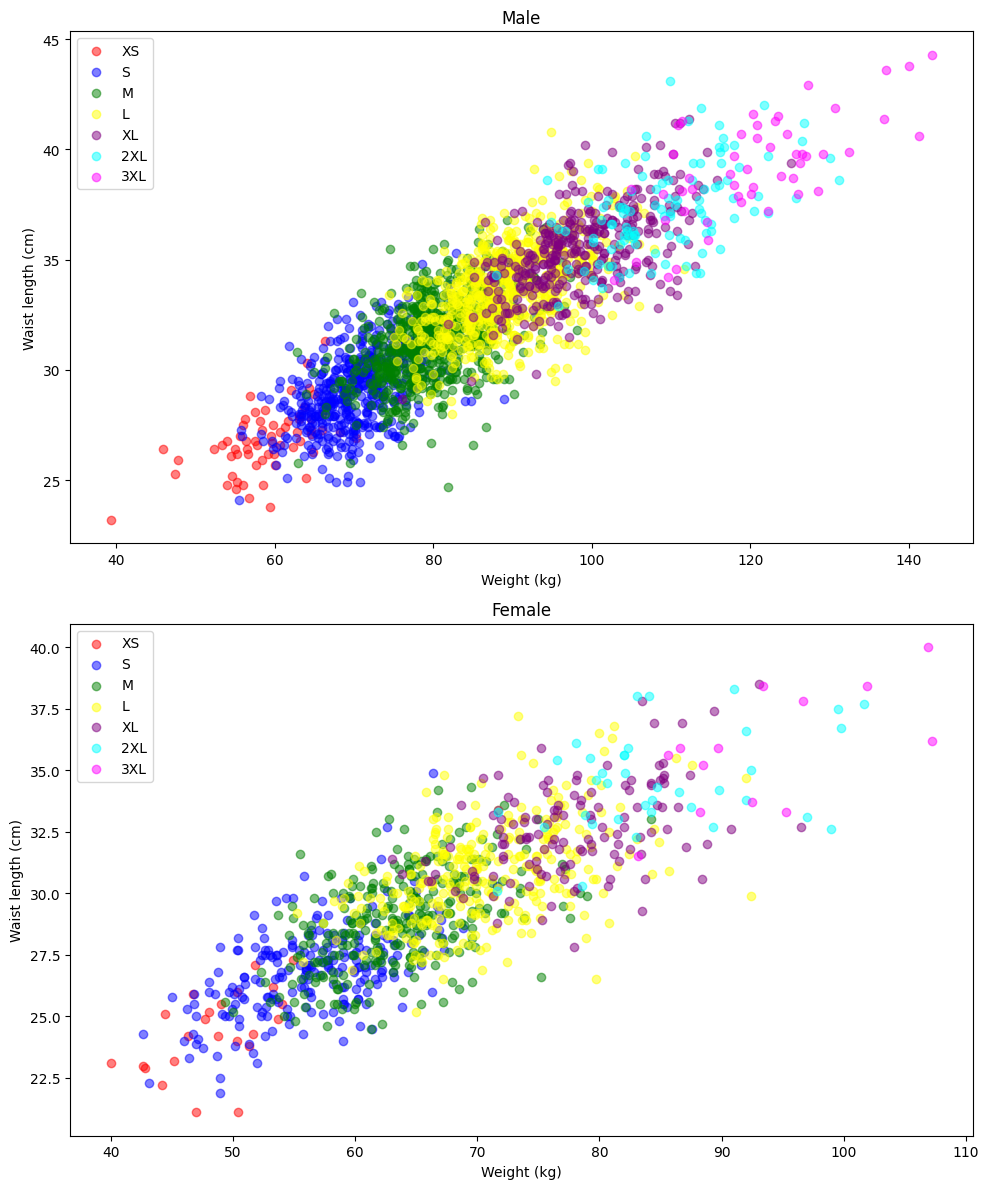

In [899]:
import matplotlib.pyplot as plt


# First let us define a dict to match a t-shirt size to a color
colors = {
    'XS': 'red',
    'S': 'blue',
    'M': 'green',
    'L': 'yellow',
    'XL': 'purple',
    '2XL': 'cyan',
    '3XL': 'magenta'
}

male_dataset = pd.read_csv('./male_sized.csv')
female_dataset = pd.read_csv('./female_sized.csv')
# For male_dataset
male_dataset.loc[:, 'waistbreadth'] = male_dataset['waistbreadth'] / 10
male_dataset.loc[:, 'weightkg'] = male_dataset['weightkg'] / 10

# For female_dataset
female_dataset.loc[:, 'waistbreadth'] = female_dataset['waistbreadth'] / 10
female_dataset.loc[:, 'weightkg'] = female_dataset['weightkg'] / 10

# Create plots for each gender
fig, axes = plt.subplots(nrows=2, figsize=(10, 12))

for ax, gender_data, gender in zip(axes, [male_dataset, female_dataset], ["Male", "Female"]):
    for size, color in colors.items():
        # Filter data by size
        size_data = gender_data[gender_data["t-shirt size"] == size]

        # Plot data
        ax.scatter(size_data["weightkg"], size_data["waistbreadth"], c=color, label=size, alpha=0.5)

    ax.set_title(gender)
    ax.set_xlabel("Weight (kg)")
    ax.set_ylabel("Waist length (cm)")
    ax.legend()

plt.tight_layout()
plt.show()

In [900]:
import numpy as np

class KNNClassifier:
    def __init__(self, k=5):
        # 1. Constructor for KNNClassifier. Initializes class variables.
        self.k = k
        self.X = None
        self.y = None

    def _calculate_distance(self, x1, x2):
        """
        Calculate the Euclidean distance between two data points, x1 and x2
        """
        # 2. Calculate the Euclidean distance between two data points x1 and x2.
        return ((x1 - x2)**2).sum() ** 0.5

    def _knn_predict(self, x):
        # 3. Predict the class for a given data point x using KNN.
        return sorted([
            (self._calculate_distance(x, measurment), self.y[i])
            for i, measurment in enumerate(self.X)
        ])[:self.k]

    def fit(self, X, y):
        # 4. Train the KNN model with the given training data and labels.
        self.X = np.array(X)
        self.y = np.array(y)

    def _predict(self, neighbors):
        # 5. Determine the final prediction based on the majority class of nearest neighbors.
        labels = [n[1] for n in neighbors]
        label, count = np.unique(labels, return_counts=True)
        max_count = np.max(count)
        
        if np.sum(count == max_count) > 1:
            tied_labels = label[count == max_count]
            # 5a. In case of a tie, select the smallest class based on the order in labels.
            return min(tied_labels, key=labels.index)

        # 5b. Otherwise, select the class with the most votes.
        return label[np.argmax(count)]

    def predict(self, X):
        # 6. Make predictions for a given list of data points X.
        predictions = []
        for x in X:
            neighbors = self._knn_predict(x)
            prediction = self._predict(neighbors)
            # 6a. Add the prediction to the result list.
            predictions.append(prediction)
            
        return predictions


In [901]:
females_X = [(person['waistbreadth'], person['weightkg']) for _, person in female_dataset.iterrows()]
females_y = female_dataset['t-shirt size'].values.tolist()

In [902]:
females_y

['M',
 'XL',
 'L',
 'S',
 '2XL',
 'XL',
 '2XL',
 'L',
 'L',
 'M',
 'S',
 'S',
 'L',
 'L',
 'S',
 'M',
 'XL',
 'M',
 'L',
 'L',
 'M',
 'M',
 'S',
 'XL',
 'L',
 'L',
 'L',
 '2XL',
 'XS',
 'L',
 'XL',
 'L',
 'L',
 'M',
 'M',
 'L',
 'L',
 'L',
 '2XL',
 'M',
 'S',
 'M',
 'L',
 'L',
 'L',
 'XL',
 'M',
 'XL',
 'S',
 'M',
 'L',
 'S',
 '2XL',
 'L',
 'S',
 'L',
 'S',
 'XL',
 'S',
 'M',
 'L',
 'XL',
 'M',
 'M',
 'L',
 'L',
 'L',
 'S',
 'L',
 'S',
 '2XL',
 'S',
 'L',
 'S',
 'M',
 'S',
 '3XL',
 'M',
 'L',
 'M',
 'M',
 'M',
 'M',
 'L',
 'M',
 'S',
 'L',
 'M',
 'M',
 'XL',
 'S',
 'M',
 'XL',
 'S',
 'M',
 '3XL',
 'L',
 'M',
 'S',
 '2XL',
 '2XL',
 'L',
 'L',
 'L',
 'L',
 'S',
 'S',
 'S',
 'L',
 'S',
 'S',
 'XL',
 'M',
 'L',
 'L',
 'L',
 'XL',
 'S',
 'S',
 'M',
 'S',
 '2XL',
 'L',
 'L',
 'L',
 'S',
 'L',
 'L',
 'S',
 'S',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'XL',
 'L',
 'L',
 'M',
 'XL',
 'L',
 'L',
 'L',
 'L',
 'M',
 'L',
 'M',
 'S',
 'M',
 'L',
 'M',
 'S',
 'S',
 'S',
 'M',
 '2XL',
 'M',
 'L',
 'L',


In [903]:
model = KNNClassifier()
person = [(154, 51)]
model.fit(females_X, females_y)
prediction = model.predict(person)
prediction

[np.str_('L')]

Test Scikit-learn

In [904]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

male_X = male_dataset.drop(columns=['chestcircumference', 'biacromialbreadth', 't-shirt size'])
male_y = male_dataset['t-shirt size']
female_X = female_dataset.drop(columns=['chestcircumference', 'biacromialbreadth', 't-shirt size'])
female_y = female_dataset['t-shirt size']

male_X_train, male_X_test, male_y_train, male_y_test = train_test_split(male_X, male_y, test_size = 0.2, random_state=42)

sk_clf = KNeighborsClassifier()
sk_clf.fit(male_X_train, male_y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [905]:
predictions = sk_clf.predict(male_X_test)
predictions

array(['XL', 'S', '2XL', 'M', 'M', 'S', 'M', 'M', 'L', 'L', '3XL', 'M',
       'L', 'XL', 'S', 'L', 'L', 'L', 'S', 'L', 'M', 'M', 'L', 'M', 'XL',
       'XS', 'L', 'L', 'M', 'L', 'S', 'XL', 'M', 'M', 'S', 'L', 'L', 'L',
       'L', 'S', '3XL', 'L', 'L', '2XL', 'S', 'L', 'S', 'M', 'S', '2XL',
       '2XL', 'L', 'L', '2XL', 'M', 'S', 'M', 'S', 'L', 'L', 'L', 'L',
       'XL', 'L', 'L', 'L', 'L', 'L', 'L', 'M', 'L', 'M', 'L', 'L', 'XL',
       'S', 'M', 'L', 'M', 'L', '3XL', 'L', 'S', 'M', 'M', 'S', 'M', 'M',
       'L', 'M', 'M', 'S', 'M', 'L', 'M', 'M', 'L', 'L', 'S', 'XL', 'M',
       '2XL', '2XL', '2XL', 'M', 'L', 'XL', 'S', 'XL', 'XL', 'L', 'XL',
       'S', 'L', 'M', '2XL', 'M', 'L', 'M', 'M', 'L', 'L', 'L', 'L',
       '3XL', 'M', 'M', 'S', 'L', 'L', 'XL', 'M', '3XL', 'XL', 'S', 'L',
       'S', 'M', 'L', 'M', '2XL', 'M', 'L', '2XL', 'S', 'XL', 'M', 'S',
       'L', '3XL', 'XL', 'L', 'XL', 'L', 'L', 'S', 'S', 'M', 'S', 'XL',
       'L', 'M', 'L', 'L', 'L', 'L', 'L', 'M', 'S', 'XL',

In [906]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(male_y_test, predictions)

accuracy

0.5957446808510638

Lab 2025-08-12

We have now had the opportunity to explore and experiment with scikit-learn, a powerful machine learning library in Python. In this lab, we specifically used the KNeighborsClassifier along with train_test_split to build and evaluate a basic classification model. This hands-on experience gave us a glimpse into how machine learning workflows operate, from data preparation to training and testing.
Although we managed to get a model up and running, there is definitely room for improvement in our test results. Today’s challenge is all about digging deeper and exploring different ways to influence and potentially improve the outcome of our model’s performance.
Whether or not you actually succeed in improving the results is not the most important part. What truly matters is that you engage deeply with the process, try different ideas, and reflect on what happens and why.

Some key questions to think about:
    Can we manipulate our data in a meaningful way to help the model learn better?
    Are there preprocessing steps we can add, such as normalization or feature scaling?
    How does changing parameters in KNeighborsClassifier affect the results?
    What impact does the way we split our data have on model accuracy?

Use this time to experiment freely. Try:
    Adjusting the number of neighbors (n_neighbors)
    Using different values for test_size in train_test_split
    Evaluating with cross_val_score instead of a single train/test split
    Visualizing the data to see if there are patterns or outliers affecting performance


Make sure to take notes on what you try, what changes you observe, and what you learn along the way. This is an excellent opportunity to develop your problem-solving skills and build intuition about machine learning models.